# 3 layer LSTM Encoder Decoder, dropout. 120 day input, 10 day forecast

In [1]:
import numpy as np
import pandas as pd
import json
import os
import math
import datetime as dt
import matplotlib.pyplot as plt
from numpy import newaxis
from keras.optimizers import Adam
from keras.layers import Conv1D, Dense, Activation, Dropout, LSTM, CuDNNLSTM, BatchNormalization, RepeatVector, TimeDistributed
from keras.models import Sequential, load_model
from sklearn.metrics import mean_squared_error, mean_absolute_error
from keras import regularizers

import utils
import model_funcs

%load_ext autoreload
%autoreload 2

plt.rcParams['figure.figsize'] = [16, 9]
%matplotlib inline

Using TensorFlow backend.


In [2]:
save_dir = 'models/lstm4.673'
df = pd.read_csv('data_25_normalized.csv', index_col='Date')
num_skew_end = 15
data = df.values[:-num_skew_end]

In [3]:
num_input = 120
num_out = 10
train_X, train_y, dev_X, dev_y, test_X, test_y, train_y_acc, dev_y_acc, test_y_acc = utils.prepare_data(data, num_input, num_preds=num_out)

train_y = train_y.reshape((train_y.shape[0], train_y.shape[1], 1))
dev_y = dev_y.reshape((dev_y.shape[0], dev_y.shape[1], 1))
test_y = test_y.reshape((test_y.shape[0], test_y.shape[1], 1))
train_y_acc = train_y_acc.reshape((train_y.shape[0], train_y.shape[1], 1))
dev_y_acc = dev_y_acc.reshape((dev_y.shape[0], dev_y.shape[1], 1))
test_y_acc = test_y_acc.reshape((test_y.shape[0], test_y.shape[1], 1))

print("train_X shape", train_X.shape)
print("train_y shape", train_y.shape)
print("dev_X shape", dev_X.shape)
print("dev_y shape", dev_y.shape)
print("test_X shape", test_X.shape)
print("test_y shape", test_y.shape)
print("train_y_acc shape", train_y_acc.shape)
print("dev_y_acc shape", dev_y_acc.shape)
print("test_y_acc shape", test_y_acc.shape)


train_X shape (585, 120, 25)
train_y shape (585, 10, 1)
dev_X shape (69, 120, 25)
dev_y shape (69, 10, 1)
test_X shape (35, 120, 25)
test_y shape (35, 10, 1)
train_y_acc shape (585, 10, 1)
dev_y_acc shape (69, 10, 1)
test_y_acc shape (35, 10, 1)


In [4]:
if not os.path.exists(save_dir): os.makedirs(save_dir)

input_shape = train_X.shape[1:]
lr = 0.0005
decay = 1e-6
dropout_rate = 0.3
epochs = 1000
batch_size = 32

model = Sequential()
model.add(Conv1D(filters=64, kernel_size=10, activation='relu', input_shape=input_shape))
model.add(CuDNNLSTM(200))
model.add(Dropout(dropout_rate))
model.add(RepeatVector(num_out))
model.add(CuDNNLSTM(200, return_sequences=True))
model.add(Dropout(dropout_rate))
model.add(TimeDistributed(Dense(100, activation='relu')))
model.add(TimeDistributed(Dense(1)))

opt = Adam(lr=lr, decay=decay)
model.compile(loss="mse", optimizer=opt)
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 111, 64)           16064     
_________________________________________________________________
cu_dnnlstm_1 (CuDNNLSTM)     (None, 200)               212800    
_________________________________________________________________
dropout_1 (Dropout)          (None, 200)               0         
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 10, 200)           0         
_________________________________________________________________
cu_dnnlstm_2 (CuDNNLSTM)     (None, 10, 200)           321600    
_________________________________________________________________
dropout_2 (Dropout)  

In [5]:
history = model_funcs.train(
    model,
    train_X,
    train_y,
    (dev_X, dev_y),
    epochs = epochs,
    batch_size = batch_size,
    save_dir = save_dir
)

[Model] Training Started
[Model] 1000 epochs, 32 batch size
Instructions for updating:
Use tf.cast instead.
Train on 585 samples, validate on 69 samples
Epoch 1/1000
585/585 [==============================] - 2s 4ms/step - loss: 0.0418 - val_loss: 0.0251
Epoch 2/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0137 - val_loss: 0.0104
Epoch 3/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0093 - val_loss: 0.0099
Epoch 4/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0075 - val_loss: 0.0078
Epoch 5/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0055 - val_loss: 0.0063
Epoch 6/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0046 - val_loss: 0.0081
Epoch 7/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0055 - val_loss: 0.0048
Epoch 8/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0041 - val_loss: 0.0033
Epoch 9/1000
585/585 [=========

Epoch 76/1000
585/585 [==============================] - 1s 1ms/step - loss: 7.9399e-04 - val_loss: 8.8335e-04
Epoch 77/1000
585/585 [==============================] - 1s 1ms/step - loss: 8.1635e-04 - val_loss: 0.0013
Epoch 78/1000
585/585 [==============================] - 1s 1ms/step - loss: 8.0280e-04 - val_loss: 8.8286e-04
Epoch 79/1000
585/585 [==============================] - 1s 1ms/step - loss: 7.9426e-04 - val_loss: 9.0174e-04
Epoch 80/1000
585/585 [==============================] - 1s 1ms/step - loss: 9.6339e-04 - val_loss: 7.2411e-04
Epoch 81/1000
585/585 [==============================] - 1s 1ms/step - loss: 8.4117e-04 - val_loss: 8.0670e-04
Epoch 82/1000
585/585 [==============================] - 1s 1ms/step - loss: 8.9812e-04 - val_loss: 0.0013
Epoch 83/1000
585/585 [==============================] - 1s 1ms/step - loss: 7.9106e-04 - val_loss: 7.6157e-04
Epoch 84/1000
585/585 [==============================] - 1s 1ms/step - loss: 7.2564e-04 - val_loss: 7.6188e-04
Epoch 85/

Epoch 150/1000
585/585 [==============================] - 1s 1ms/step - loss: 5.9366e-04 - val_loss: 5.3892e-04
Epoch 151/1000
585/585 [==============================] - 1s 1ms/step - loss: 5.6008e-04 - val_loss: 6.1879e-04
Epoch 152/1000
585/585 [==============================] - 1s 1ms/step - loss: 5.6843e-04 - val_loss: 6.5964e-04
Epoch 153/1000
585/585 [==============================] - 1s 1ms/step - loss: 5.9530e-04 - val_loss: 6.0990e-04
Epoch 154/1000
585/585 [==============================] - 1s 1ms/step - loss: 6.1297e-04 - val_loss: 9.6240e-04
Epoch 155/1000
585/585 [==============================] - 1s 1ms/step - loss: 7.0671e-04 - val_loss: 7.7377e-04
Epoch 156/1000
585/585 [==============================] - 1s 1ms/step - loss: 5.9228e-04 - val_loss: 5.7022e-04
Epoch 157/1000
585/585 [==============================] - 1s 1ms/step - loss: 5.3748e-04 - val_loss: 5.9908e-04
Epoch 158/1000
585/585 [==============================] - 1s 1ms/step - loss: 5.4227e-04 - val_loss: 7.9

585/585 [==============================] - 1s 1ms/step - loss: 5.4094e-04 - val_loss: 5.5603e-04
Epoch 224/1000
585/585 [==============================] - 1s 1ms/step - loss: 4.7002e-04 - val_loss: 4.9939e-04
Epoch 225/1000
585/585 [==============================] - 1s 1ms/step - loss: 4.3930e-04 - val_loss: 5.4035e-04
Epoch 226/1000
585/585 [==============================] - 1s 1ms/step - loss: 4.7699e-04 - val_loss: 5.4089e-04
Epoch 227/1000
585/585 [==============================] - 1s 1ms/step - loss: 4.3272e-04 - val_loss: 5.7675e-04
Epoch 228/1000
585/585 [==============================] - 1s 1ms/step - loss: 4.0274e-04 - val_loss: 6.4110e-04
Epoch 229/1000
585/585 [==============================] - 1s 1ms/step - loss: 5.0736e-04 - val_loss: 7.4662e-04
Epoch 230/1000
585/585 [==============================] - 1s 1ms/step - loss: 5.1118e-04 - val_loss: 7.2675e-04
Epoch 231/1000
585/585 [==============================] - 1s 1ms/step - loss: 4.3376e-04 - val_loss: 5.7505e-04
Epoch 2

585/585 [==============================] - 1s 1ms/step - loss: 4.1549e-04 - val_loss: 4.8120e-04
Epoch 297/1000
585/585 [==============================] - 1s 1ms/step - loss: 3.7437e-04 - val_loss: 4.1565e-04
Epoch 298/1000
585/585 [==============================] - 1s 1ms/step - loss: 3.9371e-04 - val_loss: 5.8339e-04
Epoch 299/1000
585/585 [==============================] - 1s 1ms/step - loss: 4.4592e-04 - val_loss: 4.7237e-04
Epoch 300/1000
585/585 [==============================] - 1s 1ms/step - loss: 4.1820e-04 - val_loss: 4.3293e-04
Epoch 301/1000
585/585 [==============================] - 1s 1ms/step - loss: 4.3311e-04 - val_loss: 6.0260e-04
Epoch 302/1000
585/585 [==============================] - 1s 1ms/step - loss: 4.4141e-04 - val_loss: 4.7951e-04
Epoch 303/1000
585/585 [==============================] - 1s 1ms/step - loss: 5.2257e-04 - val_loss: 6.6230e-04
Epoch 304/1000
585/585 [==============================] - 1s 1ms/step - loss: 4.3300e-04 - val_loss: 3.6516e-04
Epoch 3

585/585 [==============================] - 1s 1ms/step - loss: 3.5357e-04 - val_loss: 3.9300e-04
Epoch 370/1000
585/585 [==============================] - 1s 1ms/step - loss: 3.4155e-04 - val_loss: 4.2111e-04
Epoch 371/1000
585/585 [==============================] - 1s 1ms/step - loss: 3.5537e-04 - val_loss: 6.1327e-04
Epoch 372/1000
585/585 [==============================] - 1s 1ms/step - loss: 3.6521e-04 - val_loss: 6.2483e-04
Epoch 373/1000
585/585 [==============================] - 1s 1ms/step - loss: 4.0740e-04 - val_loss: 3.9406e-04
Epoch 374/1000
585/585 [==============================] - 1s 1ms/step - loss: 3.4167e-04 - val_loss: 4.6176e-04
Epoch 375/1000
585/585 [==============================] - 1s 1ms/step - loss: 4.0286e-04 - val_loss: 3.3350e-04
Epoch 376/1000
585/585 [==============================] - 1s 1ms/step - loss: 4.1206e-04 - val_loss: 5.8962e-04
Epoch 377/1000
585/585 [==============================] - 1s 1ms/step - loss: 4.2412e-04 - val_loss: 8.4206e-04
Epoch 3

585/585 [==============================] - 1s 1ms/step - loss: 3.5182e-04 - val_loss: 3.9128e-04
Epoch 443/1000
585/585 [==============================] - 1s 1ms/step - loss: 3.2521e-04 - val_loss: 3.4692e-04
Epoch 444/1000
585/585 [==============================] - 1s 1ms/step - loss: 3.0240e-04 - val_loss: 3.0631e-04
Epoch 445/1000
585/585 [==============================] - 1s 1ms/step - loss: 3.5151e-04 - val_loss: 3.3199e-04
Epoch 446/1000
585/585 [==============================] - 1s 1ms/step - loss: 3.4893e-04 - val_loss: 3.4432e-04
Epoch 447/1000
585/585 [==============================] - 1s 1ms/step - loss: 3.7660e-04 - val_loss: 4.9046e-04
Epoch 448/1000
585/585 [==============================] - 1s 1ms/step - loss: 3.1634e-04 - val_loss: 4.5371e-04
Epoch 449/1000
585/585 [==============================] - 1s 1ms/step - loss: 3.0448e-04 - val_loss: 4.1029e-04
Epoch 450/1000
585/585 [==============================] - 1s 1ms/step - loss: 3.3661e-04 - val_loss: 3.8287e-04
Epoch 4

585/585 [==============================] - 1s 1ms/step - loss: 2.9583e-04 - val_loss: 4.1327e-04
Epoch 516/1000
585/585 [==============================] - 1s 1ms/step - loss: 3.1255e-04 - val_loss: 2.9900e-04
Epoch 517/1000
585/585 [==============================] - 1s 1ms/step - loss: 3.0250e-04 - val_loss: 3.8513e-04
Epoch 518/1000
585/585 [==============================] - 1s 1ms/step - loss: 2.6990e-04 - val_loss: 2.6563e-04
Epoch 519/1000
585/585 [==============================] - 1s 1ms/step - loss: 2.7863e-04 - val_loss: 3.1309e-04
Epoch 520/1000
585/585 [==============================] - 1s 1ms/step - loss: 2.7884e-04 - val_loss: 3.4464e-04
Epoch 521/1000
585/585 [==============================] - 1s 1ms/step - loss: 2.6857e-04 - val_loss: 3.7196e-04
Epoch 522/1000
585/585 [==============================] - 1s 1ms/step - loss: 2.8080e-04 - val_loss: 2.8424e-04
Epoch 523/1000
585/585 [==============================] - 1s 1ms/step - loss: 2.9425e-04 - val_loss: 4.4995e-04
Epoch 5

585/585 [==============================] - 1s 1ms/step - loss: 2.7504e-04 - val_loss: 2.9707e-04
Epoch 589/1000
585/585 [==============================] - 1s 1ms/step - loss: 2.7164e-04 - val_loss: 3.9589e-04
Epoch 590/1000
585/585 [==============================] - 1s 1ms/step - loss: 3.3133e-04 - val_loss: 4.5051e-04
Epoch 591/1000
585/585 [==============================] - 1s 1ms/step - loss: 3.3121e-04 - val_loss: 4.3319e-04
Epoch 592/1000
585/585 [==============================] - 1s 1ms/step - loss: 3.7602e-04 - val_loss: 4.3231e-04
Epoch 593/1000
585/585 [==============================] - 1s 1ms/step - loss: 3.6232e-04 - val_loss: 3.9910e-04
Epoch 594/1000
585/585 [==============================] - 1s 1ms/step - loss: 2.9887e-04 - val_loss: 3.3987e-04
Epoch 595/1000
585/585 [==============================] - 1s 1ms/step - loss: 3.0699e-04 - val_loss: 4.1694e-04
Epoch 596/1000
585/585 [==============================] - 1s 1ms/step - loss: 2.6535e-04 - val_loss: 2.8408e-04
Epoch 5

585/585 [==============================] - 1s 1ms/step - loss: 2.4960e-04 - val_loss: 4.6453e-04
Epoch 662/1000
585/585 [==============================] - 1s 1ms/step - loss: 2.6943e-04 - val_loss: 3.0180e-04
Epoch 663/1000
585/585 [==============================] - 1s 1ms/step - loss: 2.3125e-04 - val_loss: 2.8077e-04
Epoch 664/1000
585/585 [==============================] - 1s 1ms/step - loss: 2.3321e-04 - val_loss: 2.5178e-04
Epoch 665/1000
585/585 [==============================] - 1s 1ms/step - loss: 2.4114e-04 - val_loss: 3.5376e-04
Epoch 666/1000
585/585 [==============================] - 1s 1ms/step - loss: 2.3610e-04 - val_loss: 3.5787e-04
Epoch 667/1000
585/585 [==============================] - 1s 1ms/step - loss: 2.4042e-04 - val_loss: 3.5883e-04
Epoch 668/1000
585/585 [==============================] - 1s 1ms/step - loss: 2.5564e-04 - val_loss: 3.9986e-04
Epoch 669/1000
585/585 [==============================] - 1s 1ms/step - loss: 2.3620e-04 - val_loss: 2.9879e-04
Epoch 6

585/585 [==============================] - 1s 1ms/step - loss: 2.2349e-04 - val_loss: 3.1076e-04
Epoch 735/1000
585/585 [==============================] - 1s 1ms/step - loss: 2.1016e-04 - val_loss: 2.2510e-04
Epoch 736/1000
585/585 [==============================] - 1s 1ms/step - loss: 2.2508e-04 - val_loss: 3.9834e-04
Epoch 737/1000
585/585 [==============================] - 1s 1ms/step - loss: 2.0987e-04 - val_loss: 2.6776e-04
Epoch 738/1000
585/585 [==============================] - 1s 1ms/step - loss: 2.2650e-04 - val_loss: 2.4516e-04
Epoch 739/1000
585/585 [==============================] - 1s 1ms/step - loss: 2.0378e-04 - val_loss: 2.9312e-04
Epoch 740/1000
585/585 [==============================] - 1s 1ms/step - loss: 2.0877e-04 - val_loss: 4.1033e-04
Epoch 741/1000
585/585 [==============================] - 1s 1ms/step - loss: 2.1028e-04 - val_loss: 3.3562e-04
Epoch 742/1000
585/585 [==============================] - 1s 1ms/step - loss: 2.1906e-04 - val_loss: 2.7100e-04
Epoch 7

585/585 [==============================] - 1s 1ms/step - loss: 1.9174e-04 - val_loss: 3.6592e-04
Epoch 808/1000
585/585 [==============================] - 1s 1ms/step - loss: 2.0533e-04 - val_loss: 4.3282e-04
Epoch 809/1000
585/585 [==============================] - 1s 1ms/step - loss: 1.9720e-04 - val_loss: 3.2214e-04
Epoch 810/1000
585/585 [==============================] - 1s 1ms/step - loss: 1.8637e-04 - val_loss: 2.7371e-04
Epoch 811/1000
585/585 [==============================] - 1s 1ms/step - loss: 1.8954e-04 - val_loss: 2.4936e-04
Epoch 812/1000
585/585 [==============================] - 1s 1ms/step - loss: 1.7741e-04 - val_loss: 2.1266e-04
Epoch 813/1000
585/585 [==============================] - 1s 1ms/step - loss: 1.8326e-04 - val_loss: 3.9199e-04
Epoch 814/1000
585/585 [==============================] - 1s 1ms/step - loss: 1.9099e-04 - val_loss: 2.3022e-04
Epoch 815/1000
585/585 [==============================] - 1s 1ms/step - loss: 1.9280e-04 - val_loss: 3.0363e-04
Epoch 8

585/585 [==============================] - 1s 1ms/step - loss: 1.7726e-04 - val_loss: 3.9763e-04
Epoch 881/1000
585/585 [==============================] - 1s 1ms/step - loss: 1.7869e-04 - val_loss: 4.1570e-04
Epoch 882/1000
585/585 [==============================] - 1s 1ms/step - loss: 1.8151e-04 - val_loss: 4.5787e-04
Epoch 883/1000
585/585 [==============================] - 1s 1ms/step - loss: 1.9306e-04 - val_loss: 2.9975e-04
Epoch 884/1000
585/585 [==============================] - 1s 1ms/step - loss: 1.8927e-04 - val_loss: 3.9056e-04
Epoch 885/1000
585/585 [==============================] - 1s 1ms/step - loss: 1.7686e-04 - val_loss: 3.9618e-04
Epoch 886/1000
585/585 [==============================] - 1s 1ms/step - loss: 1.8593e-04 - val_loss: 3.0111e-04
Epoch 887/1000
585/585 [==============================] - 1s 1ms/step - loss: 1.8086e-04 - val_loss: 3.7576e-04
Epoch 888/1000
585/585 [==============================] - 1s 1ms/step - loss: 1.9384e-04 - val_loss: 2.6358e-04
Epoch 8

585/585 [==============================] - 1s 1ms/step - loss: 1.5837e-04 - val_loss: 4.0256e-04
Epoch 954/1000
585/585 [==============================] - 1s 1ms/step - loss: 1.5549e-04 - val_loss: 2.1210e-04
Epoch 955/1000
585/585 [==============================] - 1s 1ms/step - loss: 1.5704e-04 - val_loss: 2.9750e-04
Epoch 956/1000
585/585 [==============================] - 1s 1ms/step - loss: 1.5489e-04 - val_loss: 2.9888e-04
Epoch 957/1000
585/585 [==============================] - 1s 1ms/step - loss: 1.5376e-04 - val_loss: 3.3118e-04
Epoch 958/1000
585/585 [==============================] - 1s 1ms/step - loss: 1.6015e-04 - val_loss: 2.7949e-04
Epoch 959/1000
585/585 [==============================] - 1s 1ms/step - loss: 1.8019e-04 - val_loss: 1.7056e-04
Epoch 960/1000
585/585 [==============================] - 1s 1ms/step - loss: 1.5211e-04 - val_loss: 3.9668e-04
Epoch 961/1000
585/585 [==============================] - 1s 1ms/step - loss: 1.5210e-04 - val_loss: 2.4668e-04
Epoch 9

In [6]:
preds_train = model.predict(train_X).squeeze()
preds_dev = model.predict(dev_X).squeeze()
preds_test = model.predict(test_X).squeeze()
print("MSE Train:", mean_squared_error(preds_train.reshape(-1,1), train_y.reshape(-1,1)))
print("MSE Dev:", mean_squared_error(preds_dev.reshape(-1,1), dev_y.reshape(-1,1)))
print("MSE Test:", mean_squared_error(preds_test.reshape(-1,1), test_y.reshape(-1,1)))

print("MAE Train:", mean_absolute_error(preds_train.reshape(-1,1), train_y.reshape(-1,1)))
print("MAE Dev:", mean_absolute_error(preds_dev.reshape(-1,1), dev_y.reshape(-1,1)))
print("MAE Test:", mean_absolute_error(preds_test.reshape(-1,1), test_y.reshape(-1,1)))

MSE Train: 0.00015559586624327063
MSE Dev: 0.00025410838471148957
MSE Test: 0.00010320244330084593
MAE Train: 0.007975044649341841
MAE Dev: 0.009637476665071905
MAE Test: 0.006888122485827565


In [7]:
import plotly.offline as py
import plotly.graph_objs as go
py.init_notebook_mode(connected=True)

l = go.Scatter(y=history.history['loss'], name='train')
v = go.Scatter(y=history.history['val_loss'], name='dev')

data = [v,l]
py.iplot(data, filename='line-mode')

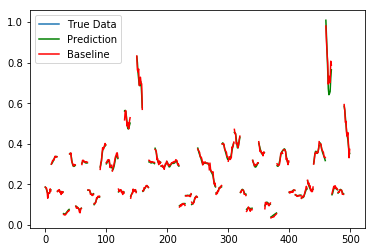

In [8]:
predicted_train = model.predict(train_X).squeeze()
predicted_train = predicted_train[::num_out]
true_train = train_y[::num_out].squeeze()
utils.plot_results_multiple(predicted_train.tolist()[:50], [], num_out, baseline_data=true_train.tolist()[:50])

# predicted_train = model.predict(train_X).squeeze()
# predicted_train = predicted_train[:, 0].reshape(-1,1)
# true_train = train_y[:, 0].reshape(-1,1)
# utils.plot_results(predicted_train[:50], true_train[:50])

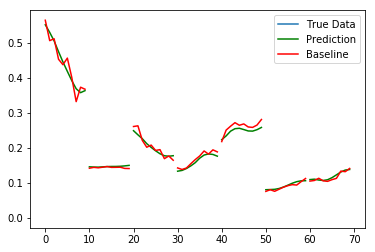

VAR MAE Dev: 0.005448766939753039
LSTM MAE Dev: 0.0001308140710455876
VAR MSE Dev: 0.005448766939753039
LSTM MSE Dev: 0.0001308140710455876


In [9]:
predicted_dev = model.predict(dev_X).squeeze()
predicted_dev = predicted_dev[::num_out]
true_dev = dev_y[::num_out].squeeze()
utils.plot_results_multiple(predicted_dev.tolist(), [0], num_out, baseline_data=true_dev.tolist())

true_dev = true_dev.reshape(-1,1)

var_preds_dev = utils.var_predict(dev_X[:, :, 0:5], num_out)
var_preds_dev = var_preds_dev[::num_out]

print("VAR MAE Dev:", mean_squared_error(var_preds_dev.reshape(-1,1), true_dev))
print("LSTM MAE Dev:", mean_squared_error(predicted_dev.reshape(-1,1), true_dev))

print("VAR MSE Dev:", mean_squared_error(var_preds_dev.reshape(-1,1), true_dev))
print("LSTM MSE Dev:", mean_squared_error(predicted_dev.reshape(-1,1), true_dev))

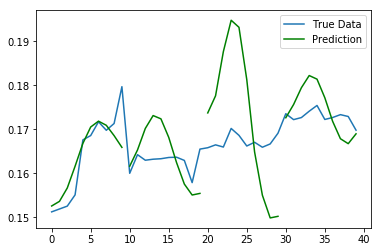

In [10]:
predicted_test = model.predict(test_X).squeeze()
predicted_test = predicted_test[::num_out]
true_test = test_y[::num_out].reshape(-1,1)
utils.plot_results_multiple(predicted_test.tolist(), true_test, num_out)

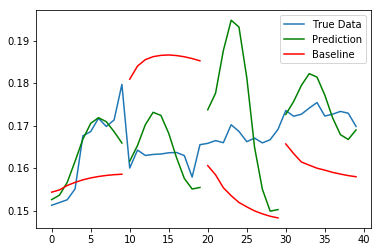

VAR MAE Test: 0.014679061944746335
LSTM MAE Test: 0.007109216662059237
VAR MSE Test: 0.0002570678369552715
LSTM MSE Test: 9.429216363396182e-05


In [11]:
var_preds = utils.var_predict(test_X[:, :, 0:5], num_out)
var_preds = var_preds[::num_out]
    
utils.plot_results_multiple(predicted_test.tolist(), true_test, num_out, baseline_data=var_preds.tolist())

print("VAR MAE Test:", mean_absolute_error(var_preds.reshape(-1,1), true_test))
print("LSTM MAE Test:", mean_absolute_error(predicted_test.reshape(-1,1), true_test))

print("VAR MSE Test:", mean_squared_error(var_preds.reshape(-1,1), true_test))
print("LSTM MSE Test:", mean_squared_error(predicted_test.reshape(-1,1), true_test))

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/scipy/signal/signaltools.py:1344: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



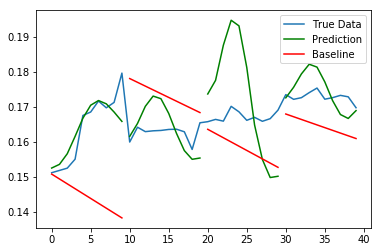

ARIMA MAE Test: 0.011817364924727753
LSTM MAE Test: 0.007109216662059237
ARIMA MSE Test: 0.00021404134489758325
LSTM MSE Test: 9.429216363396182e-05


In [12]:
arima_preds = utils.arima_predict(test_X[:, :, 0], num_out)
arima_preds = arima_preds[::num_out]
    
utils.plot_results_multiple(predicted_test.tolist(), true_test, num_out, baseline_data=arima_preds.tolist())

print("ARIMA MAE Test:", mean_absolute_error(arima_preds.reshape(-1,1), true_test))
print("LSTM MAE Test:", mean_absolute_error(predicted_test.reshape(-1,1), true_test))

print("ARIMA MSE Test:", mean_squared_error(arima_preds.reshape(-1,1), true_test))
print("LSTM MSE Test:", mean_squared_error(predicted_test.reshape(-1,1), true_test))

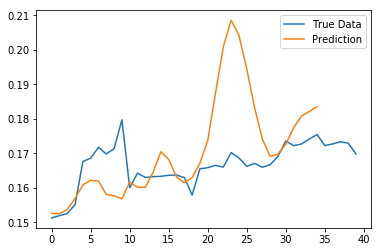

In [13]:
predicted_test_single = model.predict(test_X).squeeze()
predicted_test_single = predicted_test_single[:, 0]
utils.plot_results(predicted_test_single, true_test)

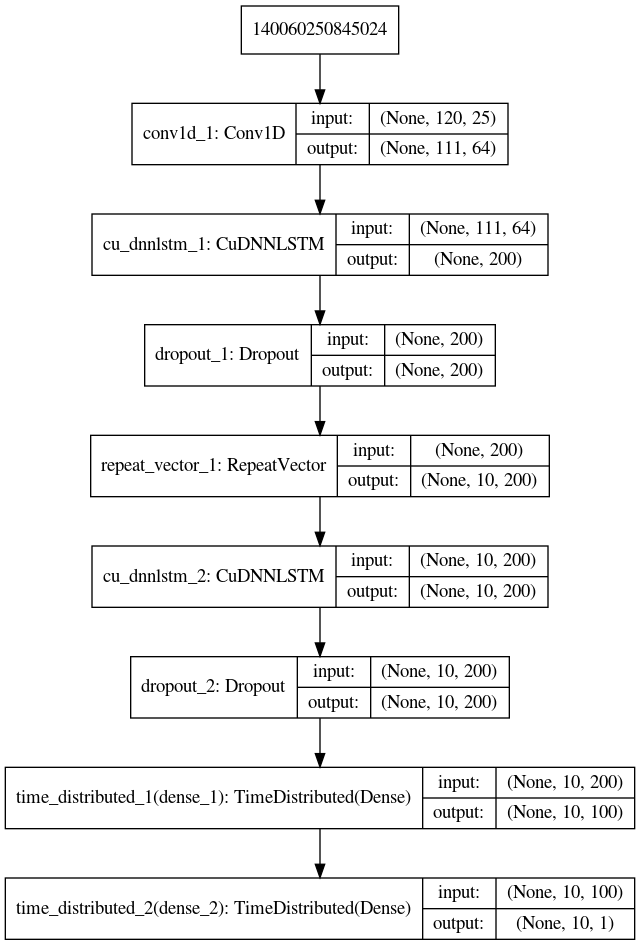

In [14]:
from IPython.display import SVG, Image, display
from keras.utils.vis_utils import plot_model

plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)
display(Image(filename='model_plot.png'))